In [ ]:
!pip install scikit-optimize
!pip install category_encoders
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import chi2_contingency



In [ ]:
from google.colab import files

uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [ ]:
data = pd.read_csv('insurance.csv')

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
X = data.drop('charges', axis = 1)
y = data['charges']

## **Exploratory Data Analysis**


### **Univariate Analysis**

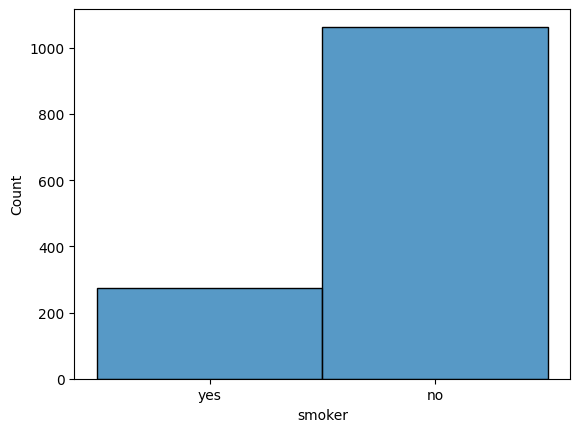

In [ ]:

sns.histplot(X['smoker'])
plt.show()


*   Target Variable(`charges`) is right-skewed. A model trained using this will likely produce residuals which do not have same variance across values of the target. This is a violation of the assumption of linear regression model(normality of residuals).

*   `age` is approximately uniformly distributed
*   `sex` approximately equal volume in each category
*   `children` is right-skewed
*   `smoker` has significant volume for `no` compared to `yes`
*   `region` approximately equal in volume









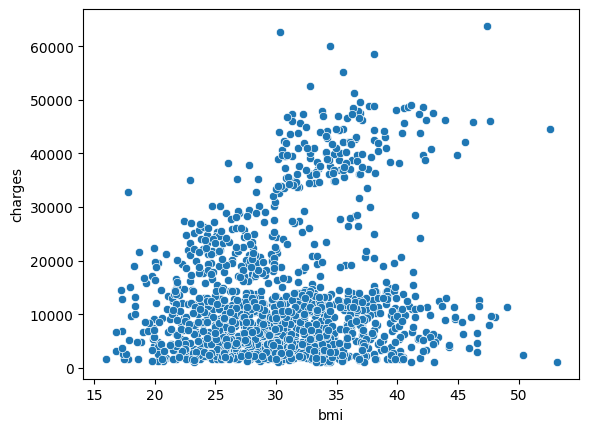

In [ ]:
#Numerical Feature Analysis
sns.scatterplot(x = 'bmi', y= 'charges', data = data)
plt.show()



*   `bmi` might show some correlation with target but their is no clear relationship. Although there seems to be a group of individuals with bmi > 30 that have charges > 30k. This group may become more apparent with bivariate analysis later.
*   `children` : No clear relationship (although `charges` seems to decrease as `children` increases). Since there are only 6 unique values for this feature, treating it as a categorical feature for the purposes of univariate analysis.



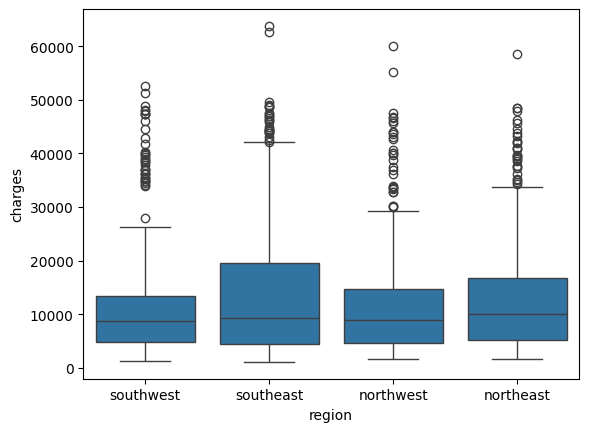

In [ ]:
sns.boxplot(x='region', y ='charges', data = data)
plt.show()



*   `sex` : No significant differences in `charges`, between the categories
*   `smoker` : `smoker` as `yes` has significantly higher `charges` compared to `no`.
*   `region` no significant difference in `charges` between the categories
*   `children` no significant difference in `charges` between the categories





### **Bivariate Analysis**

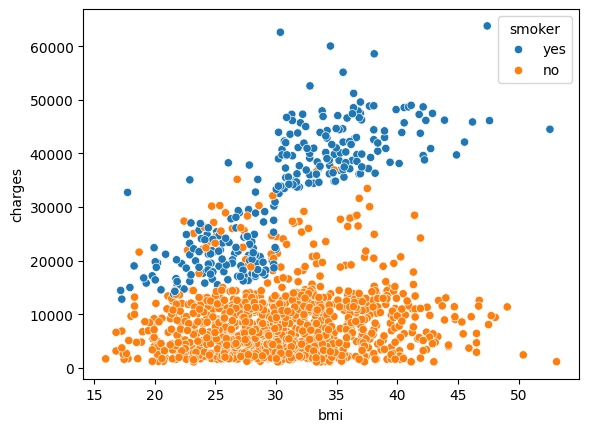

In [ ]:
# Scatterplot for numeric-categorical pair of features

sns.scatterplot(x='bmi', hue = 'smoker', y='charges', data = data)
plt.show()



*   `age-smoker` no clear trend with `charges`.
*   `bmi-smoker` : the trend for `bmi` in univariate analysis makes more sense with the `smoker` feature. The 2 trends in the univariate analysis were related to the `smoker` feature.



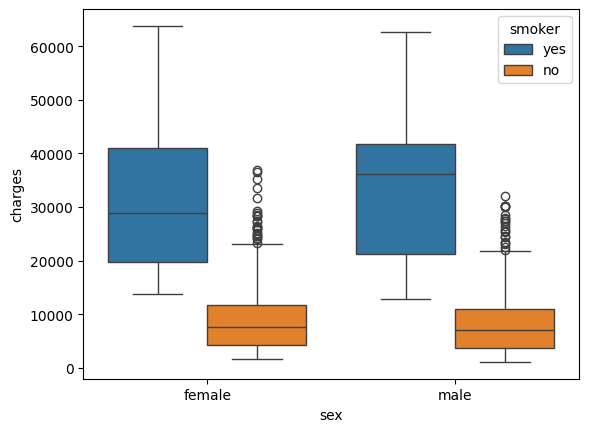

In [ ]:
# Boxplot for categorical pair of features

sns.boxplot(x='sex', hue = 'smoker', y='charges', data = data)
plt.show()

No clear relationship between the categorical features and the target variable.
Might find some more insights with the correlation tests.

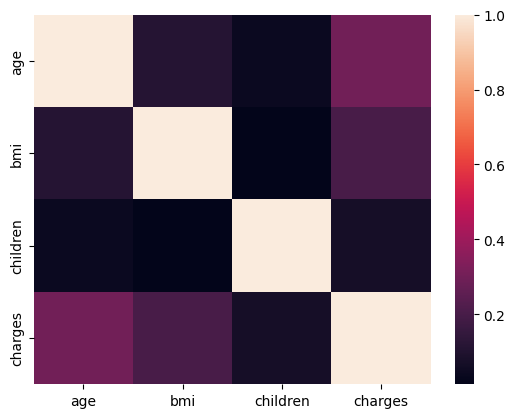

In [ ]:
# Correlation Heatmap for all numerical features

correlation_matrix = data[['age','bmi','children','charges']].corr()
sns.heatmap(correlation_matrix)
plt.show()

No additional insights can be gained

### **Correlation Test**

In [25]:
# Pearson's correlation test for numeric pair of features

corr = pg.corr(X['bmi'],X['age'])
print(corr)

            n         r         CI95%     p-val    BF10     power
pearson  1338  0.109272  [0.06, 0.16]  0.000062  103.37  0.979816




*   `age` has a very low p-value, suggesting that there might be some correlation with `charges`
*   `bmi` has a very low p-value too, suggesting some correlation with `charges`. Although, this was already seen during bivariate analysis
*   `age` and `bmi` has a very low r-value, suggesting very little correlation.
*   `bmi` and `children` has p-value > 0.05, suggesting null hypothesis is true, i.e., no correlation between the features.
*   Same for `age` and `children`
*   `Children` has very low correlation w.r.t target







In [23]:
# chi-squared test for categorical pair of features

contingency_table = pd.crosstab(X['sex'],X['region'])
result = chi2_contingency(contingency_table)

print(result)

Chi2ContingencyResult(statistic=0.43513679354327284, pvalue=0.9328921288772233, dof=3, expected_freq=array([[160.30493274, 160.79970105, 180.09566517, 160.79970105],
       [163.69506726, 164.20029895, 183.90433483, 164.20029895]]))



`sex` and `smoker` has p-value < 0.5, suggesting that there might be some correlation.



In [31]:
# ANOVA test for numeric-categorical pair

anova = pg.anova(data[['charges','smoker']], dv = 'charges', between = 'smoker')
print(anova)

   Source  ddof1  ddof2            F          p-unc       np2
0  smoker      1   1336  2177.614868  8.271436e-283  0.619765



* `age` and `smoker` has p-value > 0.05, i.e., no correlation
* `bmi` and `region` has very low p-value, suggesting there might be some correlation
* No additional insights can be drawn which was not previously understood from the bivariate analysis


## **Linear Regression**

### **Data Pre-processing**

In [32]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [33]:
# Removing unnecessary columns

drop_col = ['children','sex','region']

X_train.drop(drop_col, axis = 1, inplace = True)
X_test.drop(drop_col, axis = 1, inplace = True)





*   As per the chi-squared test, `sex` and `smoker` might be related.
*   `region` does not give much idea about the target and anova test suggest that there is correlation with `bmi`
*   `sex` had pretty weak predictive power and has some correlation with `smoker`

Collinearity of features is a violation of a assumption of linear regression model, thus the mentioned features were removed.

For processing categorical variables, they need to be transformed to numerical data. Used One-Hot Encoding for the same.



In [ ]:
# Encoding

ohe = OneHotEncoder(use_cat_names = True)
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
X_train.drop('smoker_no', axis=1, inplace = True)
X_test.drop('smoker_no', axis=1, inplace=True)

From the univariate analysis, it was found the target variable is right-skewed.
One of the assumptions of linear regression models is normality of residuals. For these reason, the target variable needs to be transformed.

In [ ]:
pt = PowerTransformer(method = 'yeo-johnson')

y_train_t = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_t = pt.transform(y_test.values.reshape(-1,1))

pd.DataFrame(y_train_t).head()

,0
0,-0.256043
1,1.670532
2,1.659210
3,-1.726664
4,1.890834


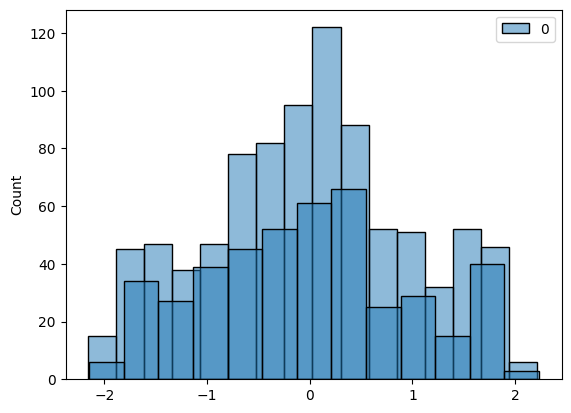

In [ ]:
sns.histplot(y_train_t, alpha = 0.5)
sns.histplot(y_test_t)
plt.show()

Transformed target variables look more normally distributed

### **Linear Regression Model**

In [34]:
#Using the target column as sample weight but scaling down to penalize high values
sample_weight = y_train/y_train.min()

In [ ]:
lr = LinearRegression()

lr.fit(X_train, y_train_t, sample_weight = sample_weight)

LinearRegression()

### **Model Evaluation**

In [ ]:
#Since model was trained on transformed data, it can be used to predict the original training data as well as the test data
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Appyling inverse transform to predictions

y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1,1))

pd.DataFrame(y_pred_train).head()

,0
0,8777.578447
1,36540.808659
2,35178.955025
3,7552.722287
4,54735.617131


In [ ]:
# RMSE as model evaluation metrics

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("rmse_train : ", rmse_train,"\n"
      "rmse_test : ", rmse_test)

rmse_train :  5964.0300795252915 
rmse_test :  5752.477398059848


## **Alternate Model : XGBoost Regressor**

### **Recursive Feature Elimination**


Using RFE to for feature selection by checking the importance of features ranked by their predictive power and BayesSearchCV for hyperparameter tuning.
These will be done by using sklearn's Pipeline class, to optimize the model.


In [ ]:
rfe = RFE(estimator = XGBRegressor())
xgb = XGBRegressor()

steps = [
    ('rfe',rfe),
    ('xgb',xgb)
]

In [ ]:
pipe = Pipeline(steps)

In [ ]:
#Defining parameters related to each step of the pipeline
num_features = X_train.shape[1]

search_spaces = {
    'rfe__n_features_to_select' : Integer(1,num_features),  #number of features to be selected
    'xgb__n_estimators' : Integer(1,500),  #number of trees built by XGBoost
    'xgb__max_depth' : Integer(2,8),  #Max depth of trees built by XGBoost
    'xgb__reg_lambda' : Integer(1,200), #Regularization parameter (lambda) to prevent overfitting
    'xgb__learning_rate' : Real(0,1), #Learning rate of the model
    'xgb__gamma' : Real(0,2000) #Parameter for pruning the decision trees
}

### **BayesSearchCV for Hyperparameter tuning**

In [ ]:
xgb_bs_cv = BayesSearchCV(
    estimator = pipe, #Pipeline
    search_spaces = search_spaces,  #Search Spaces
    scoring = 'neg_root_mean_squared_error',  #Scoring metric used by BayesSearchCV for optimization
    n_iter = 70,  #number of iterations for optimization
    cv = 3, #number of folds for cross-validation
    verbose = 1,  #Progress display
    random_state = 0  #Esnuring reproducible results
)

In [ ]:
xgb_bs_cv.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('rfe',
                                         RFE(estimator=XGBRegressor(base_score=None,
                                                                    booster=None,
                                                                    callbacks=None,
                                                                    colsample_bylevel=None,
                                                                    colsample_bynode=None,
                                                                    colsample_bytree=None,
                                                                    device=None,
                                                                    early_stopping_rounds=None,
                                                                    enable_categorical=False,
                                                                    eval_metric=None,
                                                                    feature_types=None,
                                                                    gamma=None,
                                                                    grow_policy=None,
                                                                    importance_type=None,
                                                                    interaction...
                             'xgb__gamma': Real(low=0, high=2000, prior='uniform', transform='normalize'),
                             'xgb__learning_rate': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'xgb__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=1, high=500, prior='uniform', transform='normalize'),
                             'xgb__reg_lambda': Integer(low=1, high=200, prior='uniform', transform='normalize')},
              verbose=1)

In [ ]:
#Prediction using XGBoost model
y_pred_train_xgb = xgb_bs_cv.predict(X_train)
y_pred_test_xgb = xgb_bs_cv.predict(X_test)


### **Model Evaluation**

In [ ]:
rmse_train_xgb = np.sqrt(mean_squared_error(y_train,y_pred_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))

print("rmse_train_xgb : ", rmse_train_xgb,"\n"
      "rmse_test_xgb : ", rmse_test_xgb, "\n"
      "rmse_train_linear : ", rmse_train, "\n"
      "rmse_test_linear : ", rmse_test )

rmse_train_xgb :  4219.229578404886 
 rmse_test_xgb :  4611.9465613451375 
rmse_train_linear :  5964.0300795252915 
rmse_test_linear :  5752.477398059848


As compared to the baseline linear regression model, XGBoost Regressor has lower error in forecasting insurance